In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pandas_ta as ta
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
import warnings
import quantstats as qs
warnings.filterwarnings("ignore")


In [2]:
bist100=pd.read_excel("./excel/bist100.xlsx")
bist100=bist100["Kod"].values
for i in range(len(bist100)):
    bist100[i]=bist100[i]+".IS"

In [3]:
son=pd.read_excel("./excel/FiyatPenceresi.Xlsx")
son=son[["Kod","Son.Fyt","Hcm","Yks","Dşk"]]
son.columns=["Hisse","Adj Close","Volume","High","Low"]
son=son.iloc[:-1,:]
son=son.dropna()


In [4]:
hisseler=son["Hisse"].values
hisseler=np.array(hisseler)

In [5]:
for i in range(len(hisseler)):
    hisseler[i]=hisseler[i]+".IS"

In [6]:
df=pd.DataFrame()
for hisse in hisseler:
    hisse_verileri = yf.download(hisse,start="2010-01-01")  # Örnek tarih aralığı
    hisse_kapanis = hisse_verileri[['High','Low','Open','Close','Volume']]
    hisse_kapanis["Hisse"]=hisse
    hisse_kapanis.loc[hisse_kapanis["Close"] > hisse_kapanis["High"], "High"] = hisse_kapanis["Close"]
    hisse_kapanis.loc[hisse_kapanis["Close"] < hisse_kapanis["Low"], "Low"] = hisse_kapanis["Close"]

    df=pd.concat([df,hisse_kapanis],axis=0)
df

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

,High,Low,Open,Close,Volume,Hisse
Date,,,,,,
2023-06-15,27.500000,27.500000,27.500000,27.500000,262214,A1CAP.IS
2023-06-16,30.240000,30.240000,30.240000,30.240000,1169499,A1CAP.IS
2023-06-20,31.100000,29.940001,31.000000,29.940001,8064437,A1CAP.IS
2023-06-21,26.959999,26.959999,26.959999,26.959999,2147415,A1CAP.IS
2023-06-22,27.620001,25.500000,25.620001,25.940001,71898180,A1CAP.IS
...,...,...,...,...,...,...
2024-06-05,8.070000,7.670000,7.970000,7.690000,2326506,ZRGYO.IS
2024-06-06,7.760000,7.530000,7.690000,7.540000,1654700,ZRGYO.IS
2024-06-07,8.080000,7.500000,7.600000,7.570000,13008816,ZRGYO.IS


In [7]:
ddata=df.copy()

In [8]:
df=ddata

In [9]:
df["Volume"]=df["Close"]*df["Volume"]

In [10]:
df["Close"]=np.round(df["Close"],2)
df["High"]=np.round(df["High"],2)
df["Low"]=np.round(df["Low"],2)
df["Open"]=np.round(df["Open"],2)

In [11]:
df.columns=['High', 'Low', 'Open', 'Adj Close', 'Volume', 'Hisse']

In [12]:
df["Kademe"] = np.where(df["Adj Close"] < 20, 0.01,
                np.where(df["Adj Close"] < 50, 0.02,
                    np.where(df["Adj Close"] < 100, 0.05,
                        np.where(df["Adj Close"] < 250, 0.1,
                            np.where(df["Adj Close"] < 500, 0.25,
                                np.where(df["Adj Close"] < 1000, 0.5,
                                    np.where(df["Adj Close"] < 2500, 1, 2.5)
                                )  # Buradaki parantez eksikti.
                            )
                        )
                    )
                )
            )


In [13]:
df["Tavan"]=((((df["Adj Close"].shift(1))*1.1)/df["Kademe"]).fillna(0).astype(int))*df["Kademe"]
df["Tavan"]=np.round(df["Tavan"],2)

In [14]:
df["Tavan Kontrol"]=np.where((df["Tavan"]==df["Adj Close"]),1,0)
df

,High,Low,Open,Adj Close,Volume,Hisse,Kademe,Tavan,Tavan Kontrol
Date,,,,,,,,,
2023-06-15,27.50,27.50,27.50,27.50,7.210885e+06,A1CAP.IS,0.02,0.00,0
2023-06-16,30.24,30.24,30.24,30.24,3.536565e+07,A1CAP.IS,0.02,30.24,1
2023-06-20,31.10,29.94,31.00,29.94,2.414492e+08,A1CAP.IS,0.02,33.26,0
2023-06-21,26.96,26.96,26.96,26.96,5.789431e+07,A1CAP.IS,0.02,32.92,0
2023-06-22,27.62,25.50,25.62,25.94,1.865039e+09,A1CAP.IS,0.02,29.64,0
...,...,...,...,...,...,...,...,...,...
2024-06-05,8.07,7.67,7.97,7.69,1.789083e+07,ZRGYO.IS,0.01,8.74,0
2024-06-06,7.76,7.53,7.69,7.54,1.247644e+07,ZRGYO.IS,0.01,8.45,0
2024-06-07,8.08,7.50,7.60,7.57,9.847674e+07,ZRGYO.IS,0.01,8.29,0


In [15]:
df=df.drop(["Kademe","Tavan"],axis=1)

In [16]:
import pandas_ta as ta
df["RSI"]=ta.rsi(df["Adj Close"],14)
df["SMA 5"]=df["Adj Close"].rolling(5).mean()
df["SMA 10"]=df["Adj Close"].rolling(5).mean()
df["SMA 200"]=df["Adj Close"].rolling(5).mean()




df["Bağıl Hacim"] = df["Volume"] / df["Volume"].rolling(10).mean()



# ADX, DMI, Aroon
adx_data = ta.adx(df["High"], df["Low"], df["Adj Close"], 14)
df["ADX"], df["DMIP"], df["DMIN"] = adx_data.iloc[:, 0], adx_data.iloc[:, 1], adx_data.iloc[:, 2]




def calculate_stoch_rsi(data, rsi_period=14, stochastic_period=14, k_period=3, d_period=3):
    rsi = ta.rsi(data["Adj Close"], rsi_period)
    stoch_rsi = (rsi - rsi.rolling(window=stochastic_period).min()) / (rsi.rolling(window=stochastic_period).max() - rsi.rolling(window=stochastic_period).min())
    stoch_rsi_k = stoch_rsi.rolling(window=k_period).mean() * 100
    stoch_rsi_d = stoch_rsi_k.rolling(window=d_period).mean()
    data['StochRSI_%K'] = stoch_rsi_k
    data['StochRSI_%D'] = stoch_rsi_d
    return data

df = calculate_stoch_rsi(df)


def calculate_macd(data, short_period=12, long_period=26, signal_period=9):
    data['EMA_12'] = ta.ema(data['Adj Close'], short_period)
    data['EMA_26'] = ta.ema(data['Adj Close'], long_period)
    data['MACD'] = data['EMA_12'] - data['EMA_26']
    data['Signal_Line'] = ta.ema(data['MACD'], signal_period)
    data['MACD_above_Signal'] = (data['MACD'] > data['Signal_Line']).astype(float)
    return data

df = calculate_macd(df)



# Diğer Göstergeler
df["DD"] = ((df["Adj Close"] / df["High"]) - 1) * 100
df["Range"] = ((df["High"] - df["Low"]) / df["Adj Close"]) * 100

df["MOM"] = ta.mom(df["Adj Close"], 10)



df["Driehaus Momentum"] = ((df["Bağıl Hacim"] > 2) & (df["RSI"] > 50) & (df["MOM"] > 1) & (df["Adj Close"] > df["SMA 5"]) & (df["Adj Close"] > df["SMA 10"]) & (df["Adj Close"] > df["SMA 200"])).astype(int)
df["MACD Yukarı Kesen"] = ((df["Bağıl Hacim"] > 1.5) & (df["MACD"] > 0) & (df["MACD_above_Signal"] == 1)).astype(int)
df["ADXDMI20"] = ((df["Bağıl Hacim"] > 1.3) & (df["ADX"] > 20) & (df["DMIP"] > df["DMIN"])).astype(int)
df["MACD+Stoch"] = ((df["Bağıl Hacim"] > 1.3) & (df["StochRSI_%K"] > df["StochRSI_%D"]) & (df["MACD_above_Signal"] == 1)).astype(int)




In [17]:
# Hareketli Ortalamalar (SMA ve EMA)
import ta as ta
df['SMA_20'] = df['Adj Close'].rolling(20).mean()
df['SMA_50'] = df['Adj Close'].rolling(50).mean()
df['EMA_20'] = ta.trend.EMAIndicator(df['Adj Close'], window=20).ema_indicator()
df['EMA_50'] = ta.trend.EMAIndicator(df['Adj Close'], window=50).ema_indicator()


# MACD (Moving Average Convergence Divergence)
df['MACD'] = ta.trend.macd(df['Adj Close'])
df['MACD_Signal'] = ta.trend.macd_signal(df['Adj Close'])
df['MACD_Diff'] = ta.trend.macd_diff(df['Adj Close'])

# Bollinger Bantları
bollinger = ta.volatility.BollingerBands(close=df['Adj Close'], window=20, window_dev=2)
df['Bollinger_High'] = bollinger.bollinger_hband()
df['Bollinger_Low'] = bollinger.bollinger_lband()
df['Bollinger_Middle'] = bollinger.bollinger_mavg()

# Göreceli Güç Endeksi (RSI)

# Stokastik Osilatör
df['Stoch_Oscillator'] = ta.momentum.stoch(df['High'], df['Low'], df['Adj Close'], window=14, smooth_window=3)

# Diğer göstergeler
df['ADX'] = ta.trend.adx(df['High'], df['Low'], df['Adj Close'], window=14)
df['CCI'] = ta.trend.cci(df['High'], df['Low'], df['Adj Close'], window=20)
df['ROC'] = ta.momentum.roc(df['Adj Close'], window=12)



In [18]:
# Geçmiş getiri oranları
df['Return_3D'] = df['Adj Close'].pct_change(3).shift(-3)
df['Return_7D'] = df['Adj Close'].pct_change(7).shift(-7)

# Momentum özellikleri
df['Momentum_3D'] = df['Adj Close'] / df['Adj Close'].shift(3) - 1
df['Momentum_7D'] = df['Adj Close'] / df['Adj Close'].shift(7) - 1

# Hareketli Ortalama Geçişleri
df['SMA_20_50'] = df['SMA_20'] - df['SMA_50']
df['EMA_20_50'] = df['EMA_20'] - df['EMA_50']



In [19]:
df["Return"]=100*((df["Open"]/df["Adj Close"].shift(2))-1)
df["Return"]=df["Return"].shift(-2)
df["Date"]=pd.to_datetime(df.index)
df


,High,Low,Open,Adj Close,Volume,Hisse,Tavan Kontrol,RSI,SMA 5,SMA 10,...,CCI,ROC,Return_3D,Return_7D,Momentum_3D,Momentum_7D,SMA_20_50,EMA_20_50,Return,Date
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-15,27.50,27.50,27.50,27.50,7.210885e+06,A1CAP.IS,0,NaN,NaN,NaN,...,NaN,NaN,-0.019636,-0.066182,NaN,NaN,NaN,NaN,12.727273,2023-06-15
2023-06-16,30.24,30.24,30.24,30.24,3.536565e+07,A1CAP.IS,1,NaN,NaN,NaN,...,NaN,NaN,-0.142196,-0.150794,NaN,NaN,NaN,NaN,-10.846561,2023-06-16
2023-06-20,31.10,29.94,31.00,29.94,2.414492e+08,A1CAP.IS,0,NaN,NaN,NaN,...,NaN,NaN,-0.134937,-0.112892,NaN,NaN,NaN,NaN,-14.428858,2023-06-20
2023-06-21,26.96,26.96,26.96,26.96,5.789431e+07,A1CAP.IS,0,NaN,NaN,NaN,...,NaN,NaN,-0.039318,-0.013353,-0.019636,NaN,NaN,NaN,-3.041543,2023-06-21
2023-06-22,27.62,25.50,25.62,25.94,1.865039e+09,A1CAP.IS,0,NaN,28.116,28.116,...,NaN,NaN,-0.010023,0.033153,-0.142196,NaN,NaN,NaN,-0.154202,2023-06-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-05,8.07,7.67,7.97,7.69,1.789083e+07,ZRGYO.IS,0,56.344675,7.930,7.930,...,84.427904,0.918635,-0.057217,NaN,-0.057598,0.072524,0.4782,0.336887,-1.170351,2024-06-05
2024-06-06,7.76,7.53,7.69,7.54,1.247644e+07,ZRGYO.IS,0,52.977055,7.860,7.860,...,35.955797,-1.694915,-0.070292,NaN,-0.052764,0.044321,0.4731,0.326401,1.458886,2024-06-06
2024-06-07,8.08,7.50,7.60,7.57,9.847674e+07,ZRGYO.IS,0,53.574695,7.742,7.742,...,53.487095,0.000000,NaN,NaN,-0.047799,0.024357,0.4654,0.317747,-3.963012,2024-06-07


In [20]:
endeks1=yf.download(tickers="XU100.IS",end="2020-07-27")/100
endeks2=yf.download(tickers="XU100.IS",start="2020-07-27")
endeks=pd.concat([endeks1,endeks2],axis=0)
df["Endeks"]=endeks["Adj Close"]
df["Endeks Return"]=100*((df["Endeks"]/df["Endeks"].shift(1))-1)
df["Endeks Return Lag"]=100*((df["Endeks"].shift(1)/df["Endeks"].shift(2))-1)
df["Return Lag"]=((df["Adj Close"]/df["Adj Close"].shift(1))-1)*100
df

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,High,Low,Open,Adj Close,Volume,Hisse,Tavan Kontrol,RSI,SMA 5,SMA 10,...,Momentum_3D,Momentum_7D,SMA_20_50,EMA_20_50,Return,Date,Endeks,Endeks Return,Endeks Return Lag,Return Lag
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-15,27.50,27.50,27.50,27.50,7.210885e+06,A1CAP.IS,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,12.727273,2023-06-15,5495.500000,NaN,NaN,NaN
2023-06-16,30.24,30.24,30.24,30.24,3.536565e+07,A1CAP.IS,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-10.846561,2023-06-16,5475.500000,-0.363934,NaN,9.963636
2023-06-20,31.10,29.94,31.00,29.94,2.414492e+08,A1CAP.IS,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-14.428858,2023-06-20,5251.600098,-4.089122,-0.363934,-0.992063
2023-06-21,26.96,26.96,26.96,26.96,5.789431e+07,A1CAP.IS,0,NaN,NaN,NaN,...,-0.019636,NaN,NaN,NaN,-3.041543,2023-06-21,5186.799805,-1.233915,-4.089122,-9.953240
2023-06-22,27.62,25.50,25.62,25.94,1.865039e+09,A1CAP.IS,0,NaN,28.116,28.116,...,-0.142196,NaN,NaN,NaN,-0.154202,2023-06-22,5428.299805,4.656050,-1.233915,-3.783383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-05,8.07,7.67,7.97,7.69,1.789083e+07,ZRGYO.IS,0,56.344675,7.930,7.930,...,-0.057598,0.072524,0.4782,0.336887,-1.170351,2024-06-05,10351.000000,-0.131212,-1.820629,-3.270440
2024-06-06,7.76,7.53,7.69,7.54,1.247644e+07,ZRGYO.IS,0,52.977055,7.860,7.860,...,-0.052764,0.044321,0.4731,0.326401,1.458886,2024-06-06,10279.700195,-0.688820,-0.131212,-1.950585
2024-06-07,8.08,7.50,7.60,7.57,9.847674e+07,ZRGYO.IS,0,53.574695,7.742,7.742,...,-0.047799,0.024357,0.4654,0.317747,-3.963012,2024-06-07,10139.000000,-1.368719,-0.688820,0.397878


In [21]:
def moving_beta(stock_returns, index_returns, window):
    covariance = stock_returns.rolling(window=window).cov(index_returns)
    variance = index_returns.rolling(window=window).var()
    beta = covariance / variance
    return beta
df["Beta"]=moving_beta(df["Return Lag"],df["Endeks Return"],20).values
df

,High,Low,Open,Adj Close,Volume,Hisse,Tavan Kontrol,RSI,SMA 5,SMA 10,...,Momentum_7D,SMA_20_50,EMA_20_50,Return,Date,Endeks,Endeks Return,Endeks Return Lag,Return Lag,Beta
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-15,27.50,27.50,27.50,27.50,7.210885e+06,A1CAP.IS,0,NaN,NaN,NaN,...,NaN,NaN,NaN,12.727273,2023-06-15,5495.500000,NaN,NaN,NaN,NaN
2023-06-16,30.24,30.24,30.24,30.24,3.536565e+07,A1CAP.IS,1,NaN,NaN,NaN,...,NaN,NaN,NaN,-10.846561,2023-06-16,5475.500000,-0.363934,NaN,9.963636,NaN
2023-06-20,31.10,29.94,31.00,29.94,2.414492e+08,A1CAP.IS,0,NaN,NaN,NaN,...,NaN,NaN,NaN,-14.428858,2023-06-20,5251.600098,-4.089122,-0.363934,-0.992063,NaN
2023-06-21,26.96,26.96,26.96,26.96,5.789431e+07,A1CAP.IS,0,NaN,NaN,NaN,...,NaN,NaN,NaN,-3.041543,2023-06-21,5186.799805,-1.233915,-4.089122,-9.953240,NaN
2023-06-22,27.62,25.50,25.62,25.94,1.865039e+09,A1CAP.IS,0,NaN,28.116,28.116,...,NaN,NaN,NaN,-0.154202,2023-06-22,5428.299805,4.656050,-1.233915,-3.783383,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-05,8.07,7.67,7.97,7.69,1.789083e+07,ZRGYO.IS,0,56.344675,7.930,7.930,...,0.072524,0.4782,0.336887,-1.170351,2024-06-05,10351.000000,-0.131212,-1.820629,-3.270440,0.750169
2024-06-06,7.76,7.53,7.69,7.54,1.247644e+07,ZRGYO.IS,0,52.977055,7.860,7.860,...,0.044321,0.4731,0.326401,1.458886,2024-06-06,10279.700195,-0.688820,-0.131212,-1.950585,0.801709
2024-06-07,8.08,7.50,7.60,7.57,9.847674e+07,ZRGYO.IS,0,53.574695,7.742,7.742,...,0.024357,0.4654,0.317747,-3.963012,2024-06-07,10139.000000,-1.368719,-0.688820,0.397878,0.761720


In [22]:
df=df.dropna()

In [23]:
df=df.sort_index()

In [24]:
df=df.drop(['Return_3D', 'Return_7D',
       'Momentum_3D', 'Momentum_7D'],axis=1)

In [25]:
target_data = {
    "2024-02-13": "PATEK.IS",
    "2024-02-15": "BORSK.IS",
    "2024-02-22": "LMKDC.IS",
    "2024-02-29": "ALVES.IS",
    "2024-03-04": "ARTMS.IS",
    "2024-03-05": "MOGAN.IS",
    "2024-03-11": ["BARMA.IS", "INVES.IS", "EDATA.IS"],
    "2024-03-21": "ODINE.IS",
    "2024-04-26": "RGYAS.IS",
    "2024-05-02": ["OBAMS.IS", "ENTRA.IS"],
    "2024-05-09": "LILAK.IS",
    "2024-05-10": "KOTON.IS",
    "2024-05-16": "ALTNY.IS",
    "2024-05-17": "KOCMT.IS",
    "2024-05-23": "HRKET.IS",
    "2024-05-27": "PEHOL.IS",
    "2024-05-28": "ONRYT.IS",
    "2024-05-29": "OZYSR.IS",
    "2024-06-04": "ALKLC.IS",
    "2024-06-06": "YIGIT.IS",
    "2024-06-07": "HOROZ.IS"
}

In [26]:
for date, stocks in target_data.items():
    if isinstance(stocks, list):
        for stock in stocks:
            df.loc[(df.index == date) & (df["Hisse"] == stock), "Tavan Kontrol"] = 1
    else:
        df.loc[(df.index == date) & (df["Hisse"] == stocks), "Tavan Kontrol"] = 1

In [27]:
son=df.loc["2024-06-10":]
ilk=df.loc[:"2024-06-07"]
ilk=ilk[(ilk["Return"]<21) & (ilk["Return"]>-19)]
result=pd.concat([ilk,son],axis=0)

In [28]:


yasak=["YYAPI","EMNIS","TETMT","RODRG","BRKO","AYES","EUKYO","YGYO","BALAT","SONME","SNKRN","KSTUR","DERIM","UZERB","MARKA","MMCAS","YAYLA"]
for i in range(len(yasak)):
    yasak[i]=yasak[i]+".IS"

In [29]:

result = result[~result['Hisse'].isin(["ISATR.IS","ISBTR.IS"])]
result = result[~result['Hisse'].isin(yasak)]
result=result.sort_index()

In [35]:
result=result[result["Tavan Kontrol"]==0]

In [31]:
"""import optuna
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

# Concatenate training and validation datasets
X = pd.concat([X_train, X_val], axis=0)
y = pd.concat([y_train, y_val], axis=0)


def objective(trial):
    # Hyperparameter space
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'random_strength': trial.suggest_int('random_strength', 1, 20),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 2, 30)
    }

    model = CatBoostRegressor(**param, verbose=0, random_seed=42, task_type="GPU")

    tscv = TimeSeriesSplit(n_splits=5)
    ort_scores = []

    for train_index, test_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)

        
        tahminler=pd.DataFrame(y_val)
        tahminler=tahminler.set_index(X_val.index)
        tahminler["Tahmin"]=model.predict(X_val)
        tahminler.columns=["Gerçek","Tahmin"]

        top_5_rows = tahminler.groupby(level=0).apply(lambda x: x.nlargest(3, columns=['Tahmin'])).dropna()
        topkar = (top_5_rows.groupby('Date')["Gerçek"].mean().cumsum() / 2)
        returns = (top_5_rows.groupby('Date')["Gerçek"].mean().cumsum() / 2).diff().dropna()
        pozitif = returns[returns > 0].mean()
        negatif = returns[returns < 0].mean()
        ort = abs(pozitif / negatif)
        
        ort_scores.append(ort)
    
    return np.mean(ort_scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

print('En iyi parametreler: ', study.best_params)
print('En iyi skor: ', study.best_value)
"""

'import optuna\nimport pandas as pd\nfrom catboost import CatBoostRegressor\nfrom sklearn.metrics import mean_squared_error\nfrom sklearn.model_selection import TimeSeriesSplit\n\n# Concatenate training and validation datasets\nX = pd.concat([X_train, X_val], axis=0)\ny = pd.concat([y_train, y_val], axis=0)\n\n\ndef objective(trial):\n    # Hyperparameter space\n    param = {\n        \'iterations\': trial.suggest_int(\'iterations\', 100, 1000),\n        \'depth\': trial.suggest_int(\'depth\', 4, 10),\n        \'learning_rate\': trial.suggest_float(\'learning_rate\', 0.01, 0.5),\n        \'random_strength\': trial.suggest_int(\'random_strength\', 1, 20),\n        \'bagging_temperature\': trial.suggest_float(\'bagging_temperature\', 0, 1),\n        \'border_count\': trial.suggest_int(\'border_count\', 1, 255),\n        \'l2_leaf_reg\': trial.suggest_int(\'l2_leaf_reg\', 2, 30)\n    }\n\n    model = CatBoostRegressor(**param, verbose=0, random_seed=42, task_type="GPU")\n\n    tscv = Time

In [32]:
params ={'iterations': 363, 'depth': 9, 'learning_rate': 0.022966443559949937, 'random_strength': 13, 'bagging_temperature': 0.6758282260679829, 'border_count': 211, 'l2_leaf_reg': 18}
model=CatBoostRegressor(**params,task_type="GPU",random_seed=123)
model.load_model("./model/bist100scaling.bin")

In [33]:
params = {'iterations': 629, 'depth': 8, 'learning_rate': 0.03984954027131234, 'random_strength': 3, 'bagging_temperature': 0.39823126184519836, 'border_count': 229, 'l2_leaf_reg': 19}
model=CatBoostRegressor(**params,task_type="GPU",random_seed=123)
model.load_model("./model/xtumykapanis.bin")

In [36]:
val=result.loc["2023-07-01":"2023-12-31"].dropna()
train=result.loc["2017-01-01":"2023-06-30"].dropna()
test=result.loc["2024-01-01":].dropna()
X_train=train[['Endeks Return','Return Lag','Range','RSI','Volume','Bağıl Hacim','DD','High', 'Low', 'Open', 'Adj Close','StochRSI_%K','MACD','ROC','MACD_Signal','MOM']]
X_test=test[['Endeks Return','Return Lag','Range','RSI','Volume','Bağıl Hacim','DD','High', 'Low', 'Open', 'Adj Close','StochRSI_%K','MACD','ROC','MACD_Signal','MOM']]
X_val=val[['Endeks Return','Return Lag','Range','RSI','Volume','Bağıl Hacim','DD','High', 'Low', 'Open', 'Adj Close','StochRSI_%K','MACD','ROC','MACD_Signal','MOM']]
y_train=train["Return"]
y_test=test["Return"]
y_val=val["Return"]

In [37]:
params = {'iterations': 406,
 'depth': 8,
 'learning_rate': 0.05908481614373525,
 'random_strength': 15,
 'bagging_temperature': 0.48897432777080385,
 'border_count': 163,
 'l2_leaf_reg': 9}
model=CatBoostRegressor(**params,task_type="GPU",random_seed=42)
model.fit(X_train,y_train)

: 

In [ ]:
tahminler=pd.DataFrame(test["Return"])
tahminler=tahminler.set_index(X_test.index)
tahminler["Tahmin"]=model.predict(X_test)
tahminler.columns=["Gerçek","Tahmin"]
tahminler["Hisse"]=test["Hisse"]
tahminler["Tavan"]=test["Tavan Kontrol"]
tahminler=tahminler[tahminler["Tavan"]==0]
top_5_rows = tahminler.groupby(level=0).apply(lambda x: x.nlargest(3, columns=['Tahmin'])).dropna()
topkar=(top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2].cumsum()/2)
returns=(top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2].cumsum()/2).diff().dropna()
pozitif=returns[returns>0].mean()
negatif=returns[returns<0].mean()
ort=abs(pozitif/negatif)
ort

1.7866456301909972

In [ ]:
top_5_rows["Para"]=100000


In [ ]:
stocks=[]
prices=[]
lot=[]
for date in top_5_rows.index.unique():
    hisse1=top_5_rows["Hisse"].loc[date].iloc[0]
    hisse2=top_5_rows["Hisse"].loc[date].iloc[1]
    hisse3=top_5_rows["Hisse"].loc[date].iloc[2]
    hisseler=[hisse1,hisse2,hisse3]
    fiyat1=df[df["Hisse"]==hisse1].loc[pd.to_datetime(date)]["Adj Close"].values[0]
    fiyat2=df[df["Hisse"]==hisse2].loc[pd.to_datetime(date)]["Adj Close"].values[0]
    fiyat3=df[df["Hisse"]==hisse3].loc[pd.to_datetime(date)]["Adj Close"].values[0]
    fiyatlar=[fiyat1,fiyat2,fiyat3]
    lot1=100000//fiyat1
    lot2=100000//fiyat2
    lot3=100000//fiyat3
    stocks.append(hisse1)
    stocks.append(hisse2)
    stocks.append(hisse3)
    prices.append(fiyat1)
    prices.append(fiyat2)
    prices.append(fiyat3)
    lot.append(lot1)
    lot.append(lot2)
    lot.append(lot3)
    print("{} tarihinde {} alındı. Fiyat:{}".format(pd.to_datetime(date)[0].strftime("%Y-%m-%d"),hisseler,fiyatlar))


2024-01-02 tarihinde ['AVPGY.IS', 'EKOS.IS', 'A1CAP.IS'] alındı. Fiyat:[39.78, 38.88, 27.94]
2024-01-03 tarihinde ['BEGYO.IS', 'SKYMD.IS', 'LRSHO.IS'] alındı. Fiyat:[3.1, 7.23, 3.42]
2024-01-04 tarihinde ['AVPGY.IS', 'SKYMD.IS', 'DMRGD.IS'] alındı. Fiyat:[38.24, 7.4, 10.6]
2024-01-05 tarihinde ['SURGY.IS', 'AVPGY.IS', 'EKOS.IS'] alındı. Fiyat:[31.26, 39.56, 46.44]
2024-01-08 tarihinde ['CWENE.IS', 'KZGYO.IS', 'ADGYO.IS'] alındı. Fiyat:[298.5, 21.14, 30.02]
2024-01-09 tarihinde ['LRSHO.IS', 'KTLEV.IS', 'MHRGY.IS'] alındı. Fiyat:[3.64, 84.8, 4.95]
2024-01-10 tarihinde ['TARKM.IS', 'DOFER.IS', 'SKYMD.IS'] alındı. Fiyat:[602.0, 28.24, 8.3]
2024-01-11 tarihinde ['LRSHO.IS', 'AVPGY.IS', 'ENERY.IS'] alındı. Fiyat:[3.72, 42.16, 113.5]
2024-01-12 tarihinde ['AGROT.IS', 'BEGYO.IS', 'DOFER.IS'] alındı. Fiyat:[15.4, 4.41, 30.88]
2024-01-15 tarihinde ['DMRGD.IS', 'SKYMD.IS', 'BEGYO.IS'] alındı. Fiyat:[12.9, 9.13, 4.26]
2024-01-16 tarihinde ['BEGYO.IS', 'SKYMD.IS', 'DMRGD.IS'] alındı. Fiyat:[4.46, 9

In [ ]:
sonuç=pd.DataFrame()
sonuç["Hisse"]=stocks
sonuç["Fiyat"]=prices
sonuç["Lot"]=lot
hisse_counts = sonuç['Hisse'].value_counts()


sonuç['Hisse_Adet'] = sonuç['Hisse'].map(hisse_counts)

sonuç

,Hisse,Fiyat,Lot,Hisse_Adet
0,AVPGY.IS,39.78,2513.0,5
1,EKOS.IS,38.88,2572.0,2
2,A1CAP.IS,27.94,3579.0,1
3,BEGYO.IS,3.10,32258.0,8
4,SKYMD.IS,7.23,13831.0,7
...,...,...,...,...
325,KCHOL.IS,209.40,477.0,1
326,GARAN.IS,98.45,1015.0,2
327,PRZMA.IS,38.18,2619.0,1
328,BIMAS.IS,491.00,203.0,1


In [ ]:
tablo=pd.DataFrame()
tablo["Hisse"]=sonuç.groupby("Hisse")["Hisse_Adet"].sum().index.values
tablo["Fiyat"]=sonuç.groupby("Hisse")["Fiyat"].mean().values
tablo["Adet"]=sonuç.groupby("Hisse")["Hisse_Adet"].sum().values
tablo["Lot"]=sonuç.groupby("Hisse")["Lot"].sum().values

In [ ]:
tablo["Para"]=tablo["Lot"]*tablo["Fiyat"]
tablo["Ağırlık"]=100*(tablo["Para"]/tablo["Para"].sum())
tablo.sort_values(by="Ağırlık",ascending=False).head(20)

,Hisse,Fiyat,Adet,Lot,Para,Ağırlık
4,AGROT.IS,25.615455,121,48104.0,1.232206e+06,3.667380
99,JANTS.IS,31.190000,121,37204.0,1.160393e+06,3.453645
110,LRSHO.IS,3.287778,81,281531.0,9.256114e+05,2.754871
69,ERSU.IS,33.100000,64,25918.0,8.578858e+05,2.553302
31,BEGYO.IS,4.343750,64,188141.0,8.172375e+05,2.432321
150,SKYMD.IS,8.960000,49,80030.0,7.170688e+05,2.134192
178,ZEDUR.IS,15.026667,36,40928.0,6.150114e+05,1.830441
163,TSGYO.IS,11.275000,36,54026.0,6.091432e+05,1.812976
30,BAYRK.IS,55.030000,25,9362.0,5.151909e+05,1.533348
145,SELGD.IS,52.614000,25,9746.0,5.127760e+05,1.526161


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29],
 [Text(0, 0, 'BASGZ.IS'),
  Text(0, 1, 'ARTMS.IS'),
  Text(0, 2, 'DENGE.IS'),
  Text(0, 3, 'UFUK.IS'),
  Text(0, 4, 'ALBRK.IS'),
  Text(0, 5, 'OYAYO.IS'),
  Text(0, 6, 'DMRGD.IS'),
  Text(0, 7, 'AVTUR.IS'),
  Text(0, 8, 'RALYH.IS'),
  Text(0, 9, 'PINSU.IS'),
  Text(0, 10, 'MAVI.IS'),
  Text(0, 11, 'EUYO.IS'),
  Text(0, 12, 'TRILC.IS'),
  Text(0, 13, 'SKYLP.IS'),
  Text(0, 14, 'KLRHO.IS'),
  Text(0, 15, 'METUR.IS'),
  Text(0, 16, 'GRSEL.IS'),
  Text(0, 17, 'KTLEV.IS'),
  Text(0, 18, 'AVPGY.IS'),
  Text(0, 19, 'DOFER.IS'),
  Text(0, 20, 'SELGD.IS'),
  Text(0, 21, 'BAYRK.IS'),
  Text(0, 22, 'TSGYO.IS'),
  Text(0, 23, 'ZEDUR.IS'),
  Text(0, 24, 'SKYMD.IS'),
  Text(0, 25, 'BEGYO.IS'),
  Text(0, 26, 'ERSU.IS'),
  Text(0, 27, 'LRSHO.IS'),
  Text(0, 28, 'JANTS.IS'),
  Text(0, 29, 'AGROT.IS')])

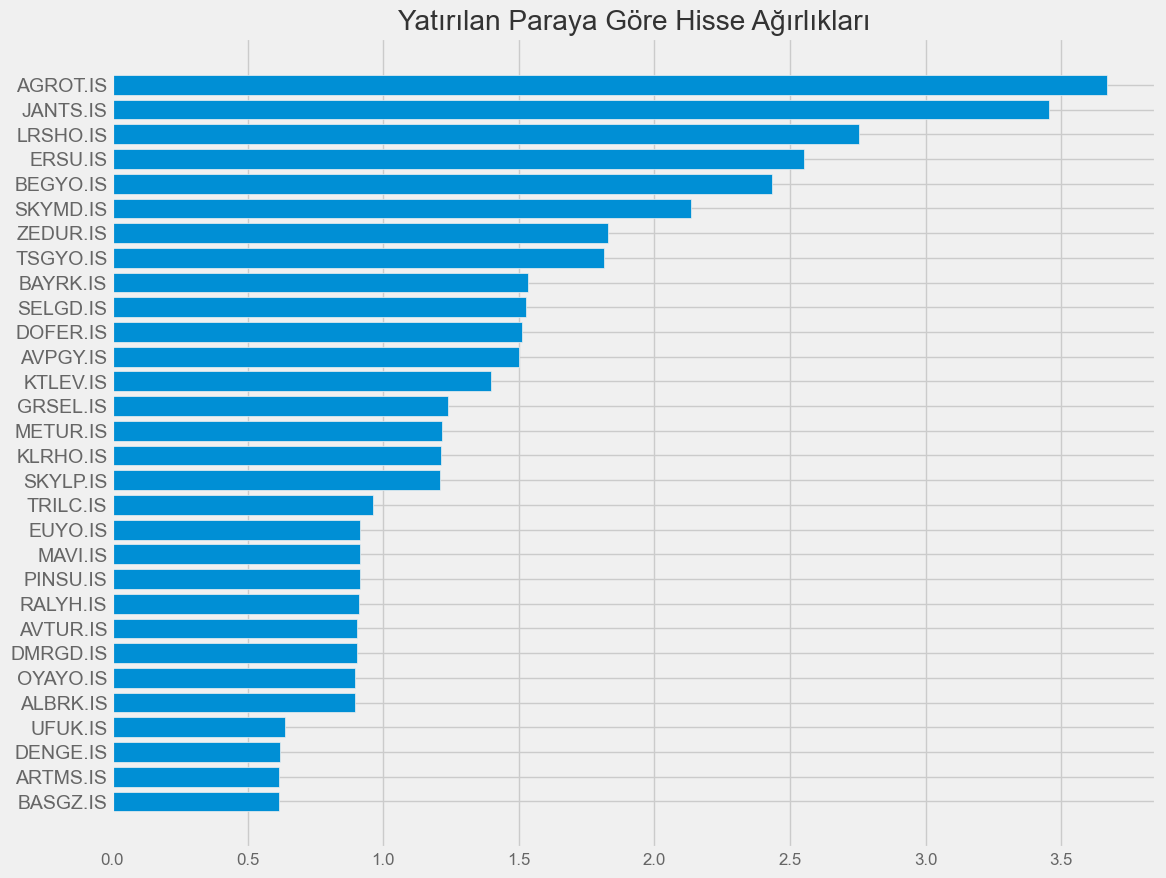

In [ ]:
plt.figure(figsize=(12,10))
plt.title("Yatırılan Paraya Göre Hisse Ağırlıkları")
plt.barh(tablo.sort_values(by="Ağırlık",ascending=True).tail(30)["Hisse"].values,tablo.sort_values(by="Ağırlık",ascending=True).tail(30)["Ağırlık"].values)
plt.yticks(fontsize=13,fontweight="bold",font="Arial")

In [ ]:
top_5_rows1=top_5_rows.copy()
top_5_rows2=top_5_rows.copy()
top_5_rows1["Gerçek"]-=0.08
top_5_rows2["Gerçek"]-=0.4

In [ ]:
kar=(((np.cumprod(1+((top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2]/2)/100)))-1)*100).iloc[-1]
returns=(top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2]/2).diff().dropna()

sharpe=kar/returns.std()
sharpe

59.011292311835064

In [ ]:
sharpes=[]
metrik=[]
adet=[]
karlar=[]
for i in range(1,30):
   top_5_rows = tahminler.groupby(level=0).apply(lambda x: x.nlargest(i, columns=['Tahmin'])).dropna()
   topkar=(((np.cumprod(1+((top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2]/2)/100)))-1)*100).iloc[-1]
   returns=(top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2]/2).diff().dropna()
   sharpe=topkar/returns.std()
   metrik.append(sharpe*topkar)
   sharpes.append(sharpe)
   adet.append(i)
   karlar.append(topkar)
sonuc=pd.DataFrame()
sonuc["Adet"]=adet
sonuc["Sharpe*Kar"]=metrik
sonuc["Sharpe"]=sharpes
sonuc["Kar"]=karlar
sonuc.sort_values(by="Kar",ascending=False)


,Adet,Sharpe*Kar,Sharpe,Kar
1,2,21367.855364,83.439645,256.087564
2,3,16527.558878,81.132103,203.711704
0,1,8390.450774,42.860884,195.760097
3,4,11480.229415,72.626561,158.072050
5,6,7103.675860,60.953574,116.542401
4,5,6675.519600,57.340822,116.418276
9,10,8301.263690,74.784932,111.001821
8,9,7294.427725,67.460076,108.129551
10,11,7469.223680,71.818431,104.001488
6,7,6077.283011,58.827246,103.307284


In [ ]:
top_5_rows=top_5_rows.droplevel(level=0)
top_5_rows1=top_5_rows1.droplevel(level=0)
top_5_rows2=top_5_rows2.droplevel(level=0)

In [ ]:
endeks=yf.download(tickers="XU100.IS",start="2023-07-01",end="2024-01-01")
endeks["Getiri"]=0
for i in range(len(endeks)):
    endeks["Getiri"].iloc[i]=100*((endeks["Adj Close"].iloc[i]/endeks["Adj Close"].iloc[0])-1)
endeks=endeks.fillna(0)
endeks

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Getiri
Date,,,,,,,
2023-07-03,5867.200195,6018.299805,5867.200195,6015.299805,6015.299805,3725885300,0.000000
2023-07-04,6049.700195,6076.700195,5980.100098,6003.899902,6003.899902,4768264400,-0.189515
2023-07-05,6026.100098,6121.600098,5889.899902,6106.799805,6106.799805,4054640000,1.521121
2023-07-06,6135.299805,6207.899902,6124.200195,6141.100098,6141.100098,4105306400,2.091339
2023-07-07,6139.799805,6223.299805,6117.100098,6187.100098,6187.100098,3663437400,2.856055
...,...,...,...,...,...,...,...
2023-12-22,7769.799805,7795.000000,7553.899902,7557.600098,7557.600098,1874128000,25.639625
2023-12-26,7303.299805,7405.100098,7202.899902,7299.299805,7299.299805,1937122200,21.345569
2023-12-27,7282.200195,7365.100098,7215.000000,7260.399902,7260.399902,2146187500,20.698887


In [ ]:
endeks1=yf.download(tickers="XU100.IS",start="2024-01-01")
endeks1["Getiri"]=0
for i in range(len(endeks1)):
    endeks1["Getiri"].iloc[i]=100*((endeks1["Adj Close"].iloc[i]/endeks1["Adj Close"].iloc[0])-1)
endeks1=endeks1.fillna(0)
endeks1

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Getiri
Date,,,,,,,
2024-01-02,7542.299805,7634.100098,7542.299805,7624.299805,7624.299805,2397081700,0.000000
2024-01-03,7624.600098,7624.600098,7411.799805,7412.000000,7412.000000,2169646100,-2.784515
2024-01-04,7421.899902,7547.799805,7387.000000,7547.799805,7547.799805,2391591200,-1.003371
2024-01-05,7570.100098,7628.700195,7532.200195,7628.700195,7628.700195,2355101900,0.057715
2024-01-08,7667.899902,7824.600098,7667.899902,7818.899902,7818.899902,2873781100,2.552367
...,...,...,...,...,...,...,...
2024-06-05,10403.200195,10434.700195,10239.599609,10351.000000,10351.000000,2695925200,35.763287
2024-06-06,10391.500000,10446.500000,10275.299805,10279.700195,10279.700195,2035557600,34.828121
2024-06-07,10322.500000,10335.799805,10112.400391,10139.000000,10139.000000,1745750000,32.982703


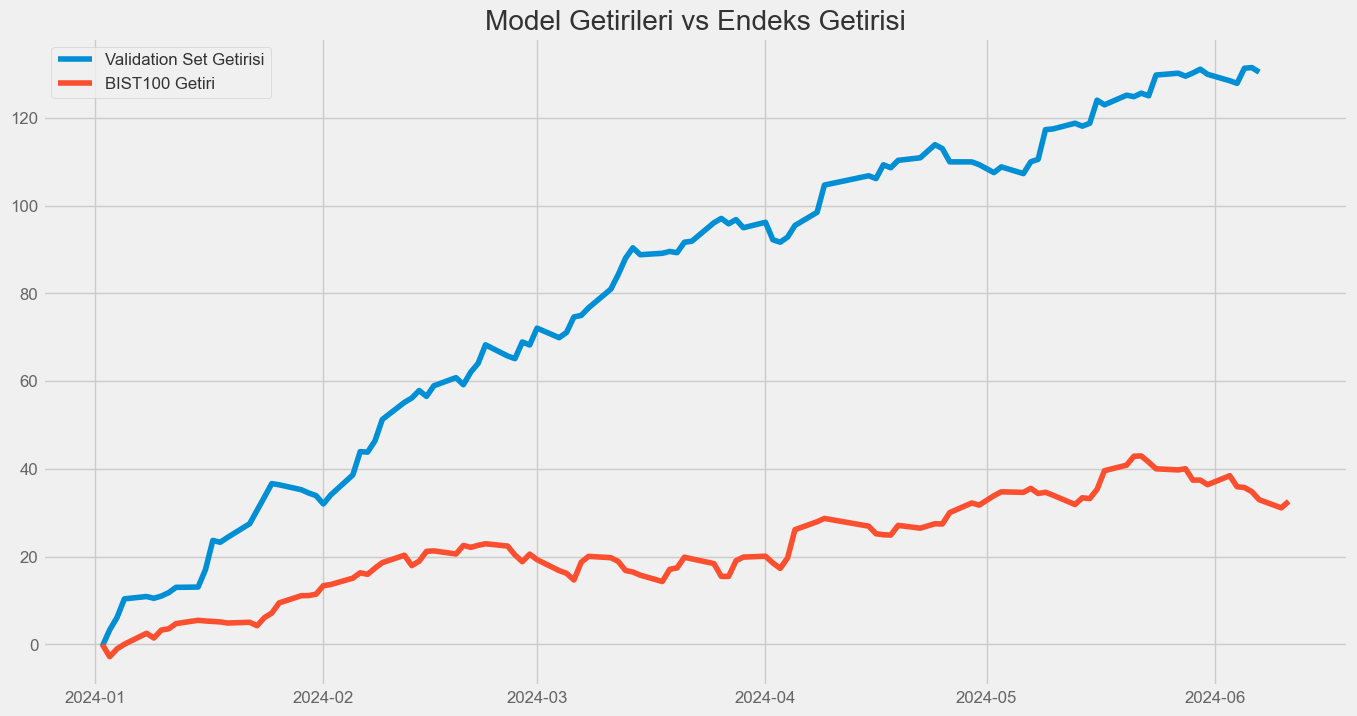

In [ ]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(15,8))
plt.title("Model Getirileri vs Endeks Getirisi")
plt.plot(top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2].cumsum()/2,label="Validation Set Getirisi")
plt.plot(endeks1["Getiri"],label="BIST100 Getiri")
legend_properties = {'fontweight':'bold'}
plt.legend()

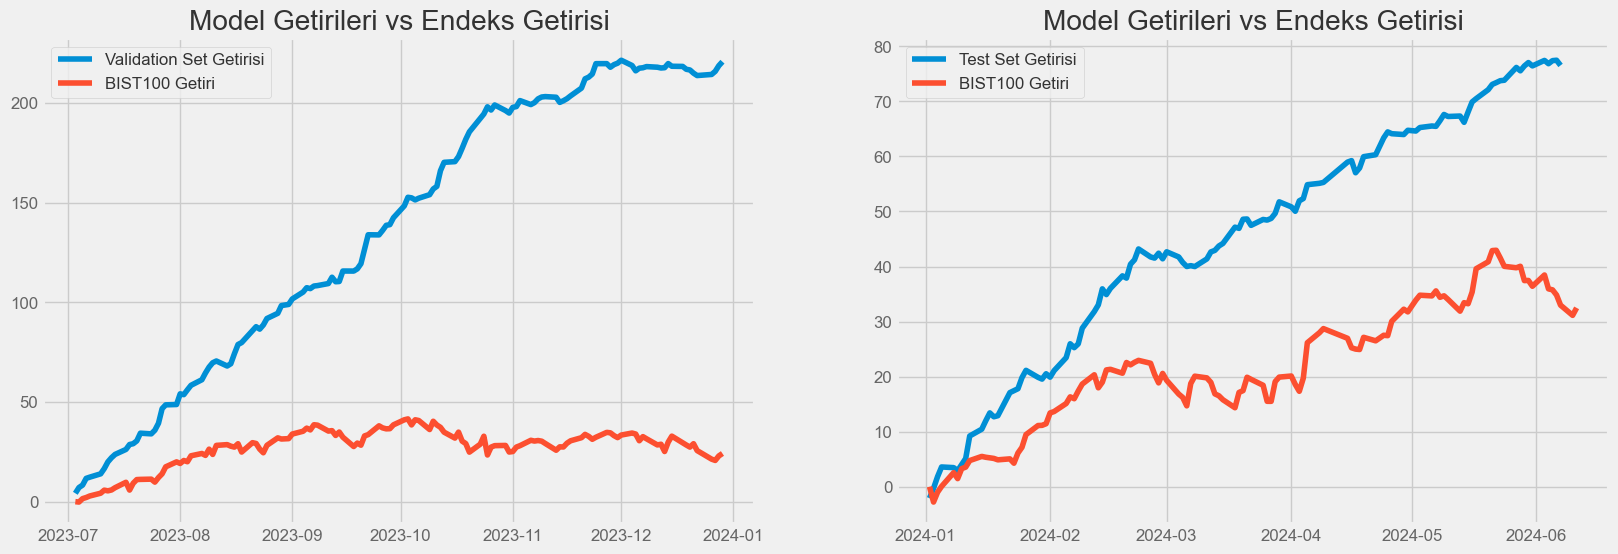

In [ ]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.title("Model Getirileri vs Endeks Getirisi")
plt.plot(top_5_rows.groupby('Date')["Gerçek"].mean().cumsum()/2,label="Validation Set Getirisi")
plt.plot(endeks["Getiri"],label="BIST100 Getiri")
legend_properties = {'fontweight':'bold'}
plt.legend()
plt.subplot(1,2,2)
plt.title("Model Getirileri vs Endeks Getirisi")
plt.plot(top_5_rows1.groupby('Date')["Gerçek"].mean().iloc[:-2].cumsum()/2,label="Test Set Getirisi")
plt.plot(endeks1["Getiri"],label="BIST100 Getiri")
legend_properties = {'fontweight':'bold'}
plt.legend()


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29],
 [Text(0, 0, 'VAKBN.IS'),
  Text(0, 1, 'EKOS.IS'),
  Text(0, 2, 'GIPTA.IS'),
  Text(0, 3, 'BINHO.IS'),
  Text(0, 4, 'ESCAR.IS'),
  Text(0, 5, 'GRSEL.IS'),
  Text(0, 6, 'BEGYO.IS'),
  Text(0, 7, 'UFUK.IS'),
  Text(0, 8, 'SURGY.IS'),
  Text(0, 9, 'GRTRK.IS'),
  Text(0, 10, 'METUR.IS'),
  Text(0, 11, 'ZEDUR.IS'),
  Text(0, 12, 'RALYH.IS'),
  Text(0, 13, 'PINSU.IS'),
  Text(0, 14, 'ETILR.IS'),
  Text(0, 15, 'ANHYT.IS'),
  Text(0, 16, 'IHAAS.IS'),
  Text(0, 17, 'KCHOL.IS'),
  Text(0, 18, 'BAYRK.IS'),
  Text(0, 19, 'RAYSG.IS'),
  Text(0, 20, 'IZFAS.IS'),
  Text(0, 21, 'TCELL.IS'),
  Text(0, 22, 'AVPGY.IS'),
  Text(0, 23, 'AGROT.IS'),
  Text(0, 24, 'DOFER.IS'),
  Text(0, 25, 'SKYMD.IS'),
  Text(0, 26, 'JANTS.IS'),
  Text(0, 27, 'TRILC.IS'),
  Text(0, 28, 'KTLEV.IS'),
  Text(0, 29, 'TSGYO.IS')])

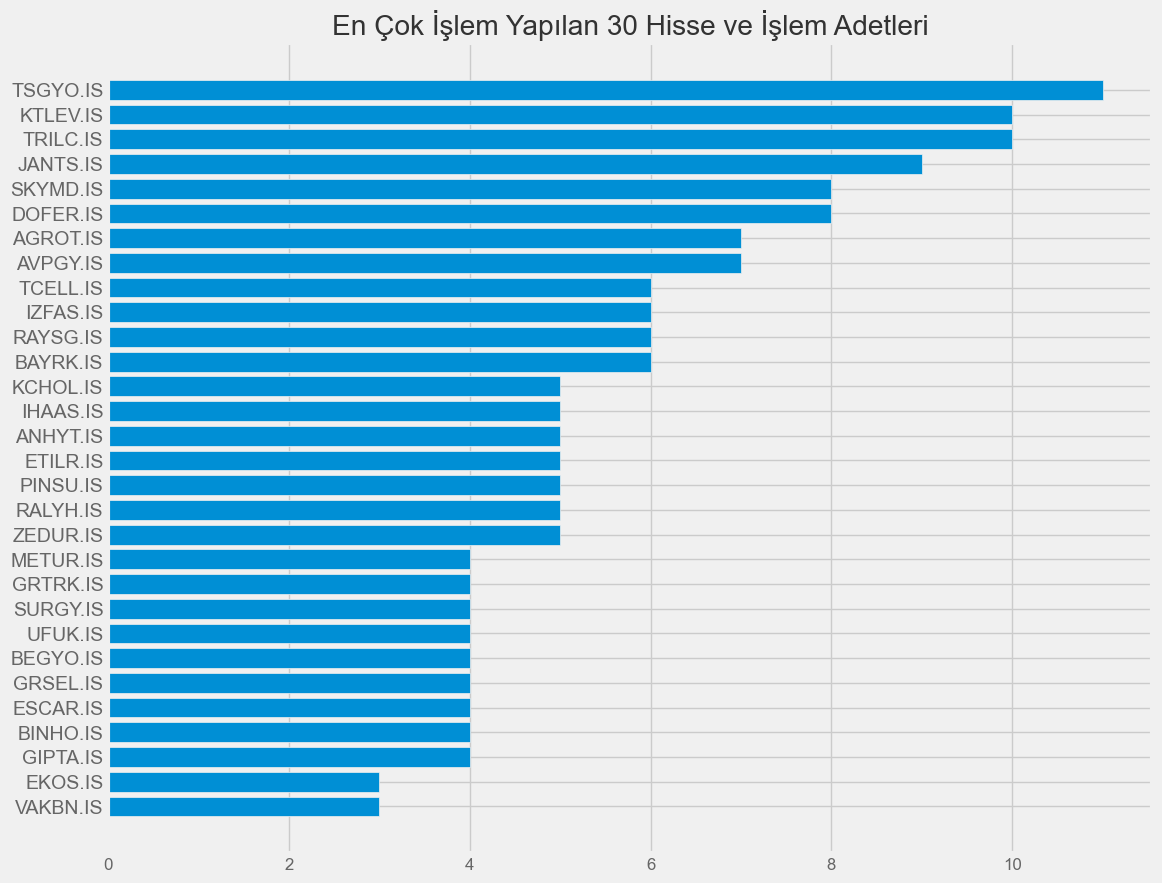

In [ ]:
plt.figure(figsize=(12,10))
plt.title("En Çok İşlem Yapılan 30 Hisse ve İşlem Adetleri")
plt.barh(top_5_rows["Hisse"].value_counts().sort_values().tail(30).index,top_5_rows["Hisse"].value_counts().sort_values().tail(30).values)
plt.yticks(fontsize=13,fontweight="bold",font="Arial")

In [ ]:

returns=top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2].dropna()/2
returns=returns/100
returns=pd.DataFrame(returns)
returns["Kar"]=np.where((returns>0),1,0)
returns
returns

,Gerçek,Kar
Date,,
2024-01-02,-0.004228,0
2024-01-03,0.037330,1
2024-01-04,0.028442,1
2024-01-05,0.042402,1
2024-01-08,0.005285,1
...,...,...
2024-06-03,-0.014615,0
2024-06-04,-0.005964,0
2024-06-05,0.034452,1


In [ ]:
def ortalama_kazanma_serisi_uzunlugu(veri):
    kazanma_serileri = []  # Kazanma serilerini tutacak bir liste oluşturuyoruz.
    current_series_length = 0  # Şu anki kazanma serisinin uzunluğunu tutacak değişken
    for num in veri:
        if num == 1:  # Eğer 1 görürsek,
            current_series_length += 1  # Kazanma serisinin uzunluğunu bir arttır.
        else:
            if current_series_length > 0:  # Eğer kazanma serisi bitmişse,
                kazanma_serileri.append(current_series_length)  # Kazanma serisinin uzunluğunu listeye ekle.
                current_series_length = 0  # Şu anki kazanma serisi uzunluğunu sıfırla.
    if current_series_length > 0:  # Eğer döngü biterken hala bir kazanma serisi varsa,
        kazanma_serileri.append(current_series_length)  # Son kazanma serisini de listeye ekle.
    
    # Kazanma serilerinin ortalama uzunluğunu hesapla.
    ortalama_uzunluk = sum(kazanma_serileri) / len(kazanma_serileri)
    
    return ortalama_uzunluk



# Fonksiyonu çağırarak ortalama kazanma serisi uzunluğunu bul
ortalama = ortalama_kazanma_serisi_uzunlugu(list(returns["Kar"].values))
print("Ortalama kazanma serisi uzunluğu:", ortalama)


Ortalama kazanma serisi uzunluğu: 2.8


In [ ]:
def ortalama_kaybetme_serisi_uzunlugu(veri):
    kaybetme_serileri = []  # Kaybetme serilerini tutacak bir liste oluşturuyoruz.
    current_series_length = 0  # Şu anki kaybetme serisinin uzunluğunu tutacak değişken
    for num in veri:
        if num == 0:  # Eğer 0 görürsek,
            current_series_length += 1  # Kaybetme serisinin uzunluğunu bir arttır.
        else:
            if current_series_length > 0:  # Eğer kaybetme serisi bitmişse,
                kaybetme_serileri.append(current_series_length)  # Kaybetme serisinin uzunluğunu listeye ekle.
                current_series_length = 0  # Şu anki kaybetme serisi uzunluğunu sıfırla.
    if current_series_length > 0:  # Eğer döngü biterken hala bir kaybetme serisi varsa,
        kaybetme_serileri.append(current_series_length)  # Son kaybetme serisini de listeye ekle.
    
    # Kaybetme serilerinin ortalama uzunluğunu hesapla.
    ortalama_uzunluk = sum(kaybetme_serileri) / len(kaybetme_serileri)
    
    return ortalama_uzunluk



# Fonksiyonu çağırarak ortalama kaybetme serisi uzunluğunu bul
ortalama = ortalama_kaybetme_serisi_uzunlugu(list(returns["Kar"].values))
print("Ortalama kaybetme serisi uzunluğu:", ortalama)


Ortalama kaybetme serisi uzunluğu: 1.4615384615384615


In [ ]:
endeks1["Return"]=(endeks1["Adj Close"]/endeks1["Adj Close"].shift(1))-1
endeks1

,Open,High,Low,Close,Adj Close,Volume,Getiri,Return
Date,,,,,,,,
2024-01-02,7542.299805,7634.100098,7542.299805,7624.299805,7624.299805,2397081700,0.000000,NaN
2024-01-03,7624.600098,7624.600098,7411.799805,7412.000000,7412.000000,2169646100,-2.784515,-0.027845
2024-01-04,7421.899902,7547.799805,7387.000000,7547.799805,7547.799805,2391591200,-1.003371,0.018322
2024-01-05,7570.100098,7628.700195,7532.200195,7628.700195,7628.700195,2355101900,0.057715,0.010718
2024-01-08,7667.899902,7824.600098,7667.899902,7818.899902,7818.899902,2873781100,2.552367,0.024932
...,...,...,...,...,...,...,...,...
2024-06-05,10403.200195,10434.700195,10239.599609,10351.000000,10351.000000,2695925200,35.763287,-0.001312
2024-06-06,10391.500000,10446.500000,10275.299805,10279.700195,10279.700195,2035557600,34.828121,-0.006888
2024-06-07,10322.500000,10335.799805,10112.400391,10139.000000,10139.000000,1745750000,32.982703,-0.013687


In [ ]:
endeks1["Kar"]=np.where((endeks1["Return"]>0),1,0)


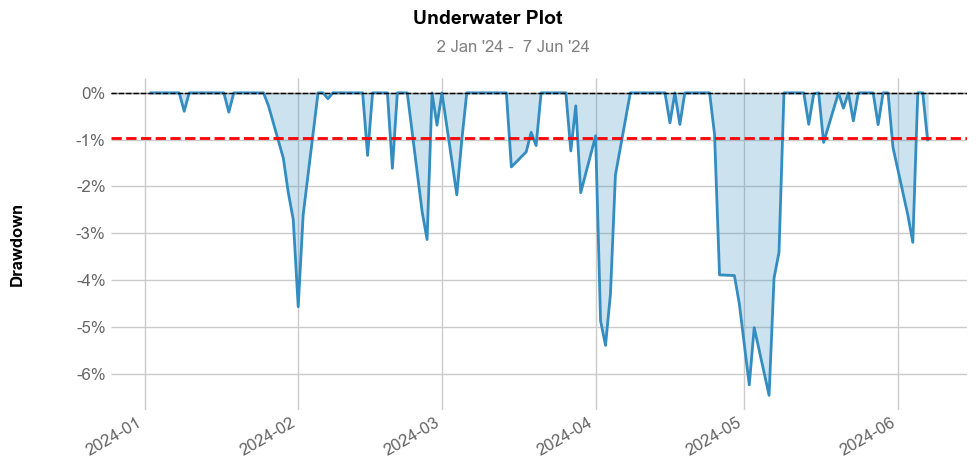

In [ ]:
qs.plots.drawdown(returns=returns["Gerçek"],lw=2)

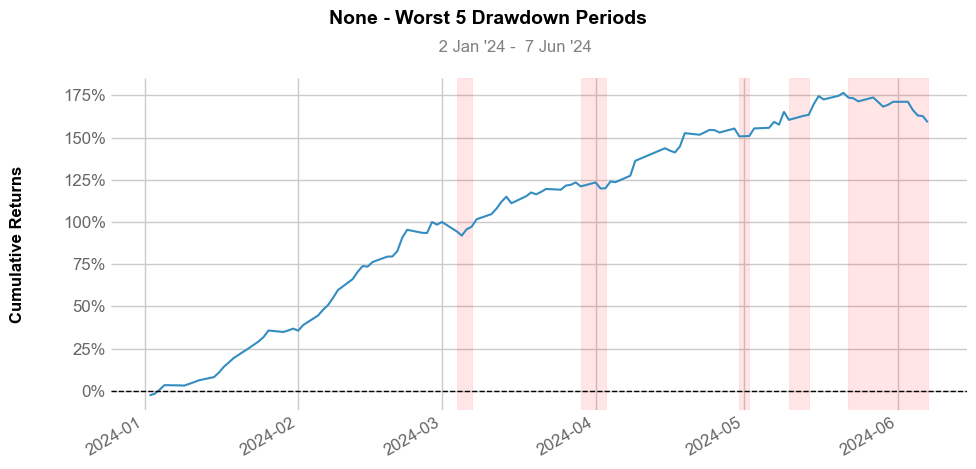

In [ ]:
qs.plots.drawdowns_periods(returns=returns["Gerçek"])

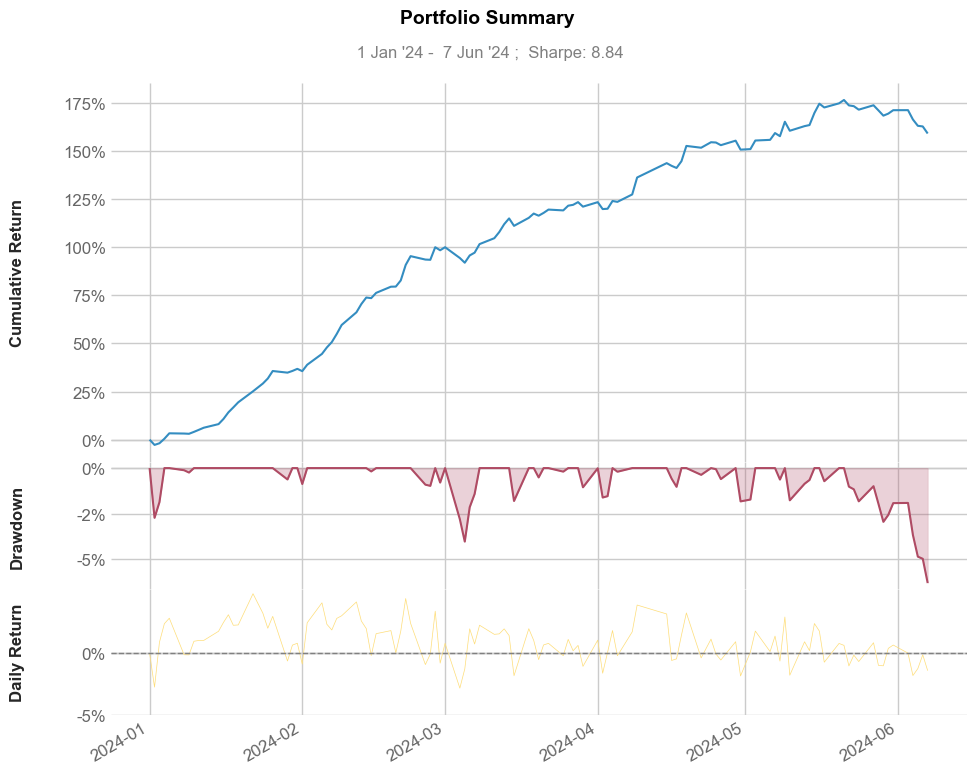

In [ ]:
qs.plots.snapshot(returns=returns["Gerçek"],benchmark=endeks1["Return"])

In [ ]:
qs.reports.html(returns=returns["Gerçek"],benchmark=endeks1["Return"])

In [ ]:
model.feature_names_

['Endeks Return',
 'Return Lag',
 'Range',
 'RSI',
 'Volume',
 'Bağıl Hacim',
 'DD',
 'High',
 'Low',
 'Open',
 'Adj Close',
 'StochRSI_%K',
 'MACD',
 'ROC',
 'MACD_Signal',
 'MOM']

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2024-01-03   2024-01-03
End Period                 2024-06-07   2024-06-07
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          32.98%       257.6%
CAGR﹪                     58.48%       683.34%

Sharpe                     3.19         8.57
Prob. Sharpe Ratio         98.56%       100.0%
Smart Sharpe               2.93         7.86
Sortino                    5.84         23.89
Smart Sortino              5.35         21.89
Sortino/√2                 4.13         16.89
Smart Sortino/√2           3.78         15.48
Omega                      4.2          4.2

Max Drawdown               -7.0%        -6.46%
Longest DD Days            39           14
Volatility (ann.)          21.78%       35.94%
R^2                        0.0          0.0
Information Ratio          0.36         0.36
Calmar            

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2024-04-25,2024-05-06,2024-05-08,14,-6.460697,-6.238614
2,2024-03-27,2024-04-03,2024-04-05,10,-5.394150,-4.867727
3,2024-01-26,2024-02-01,2024-02-02,8,-4.567838,-2.706673
4,2024-05-31,2024-06-04,2024-06-04,5,-3.193019,-2.612217
5,2024-02-26,2024-02-27,2024-02-27,2,-3.133560,-2.537844


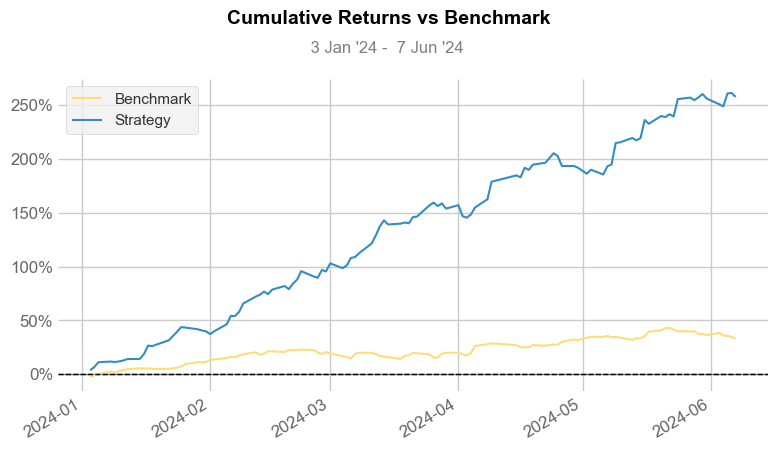

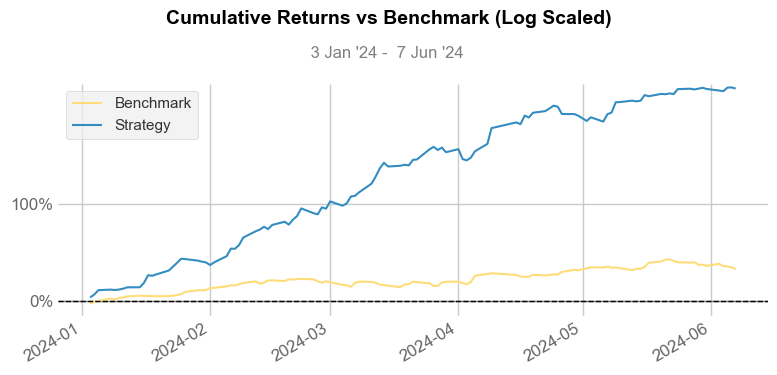

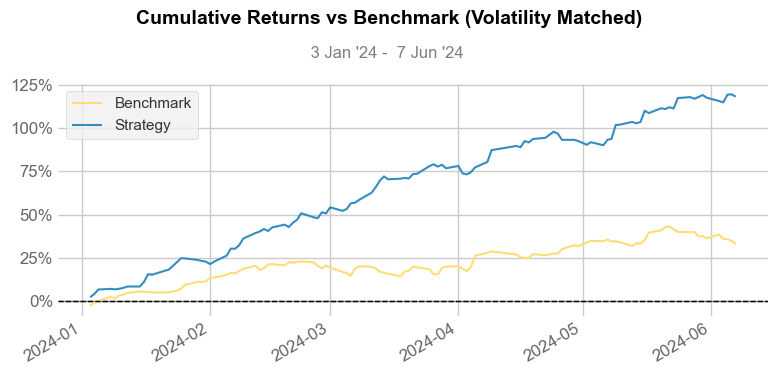

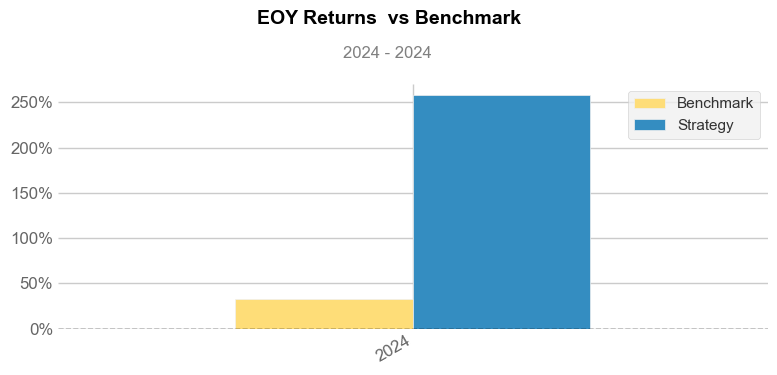

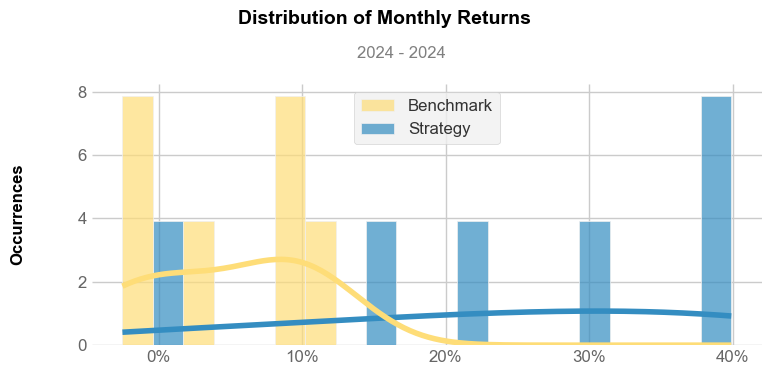

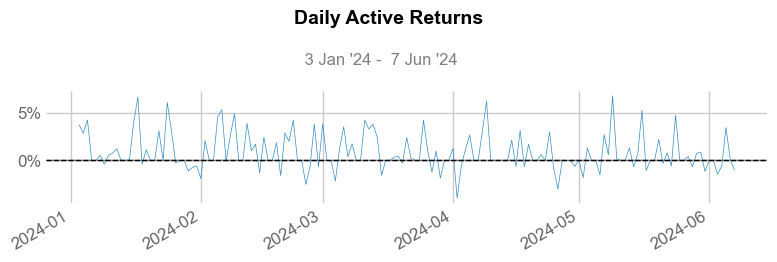

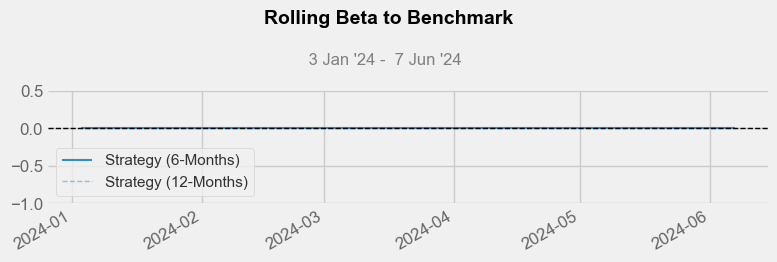

IndexError: index 0 is out of bounds for axis 0 with size 0

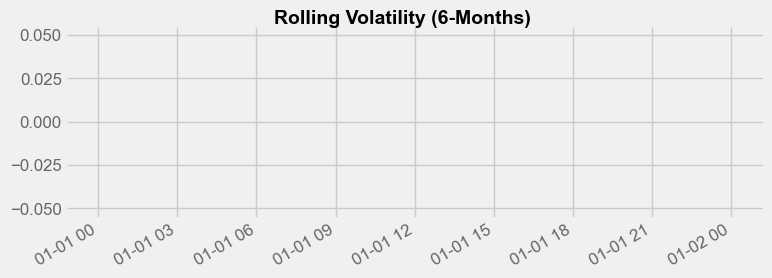

In [ ]:
qs.reports.full(returns=returns["Gerçek"],benchmark=endeks1["Return"])

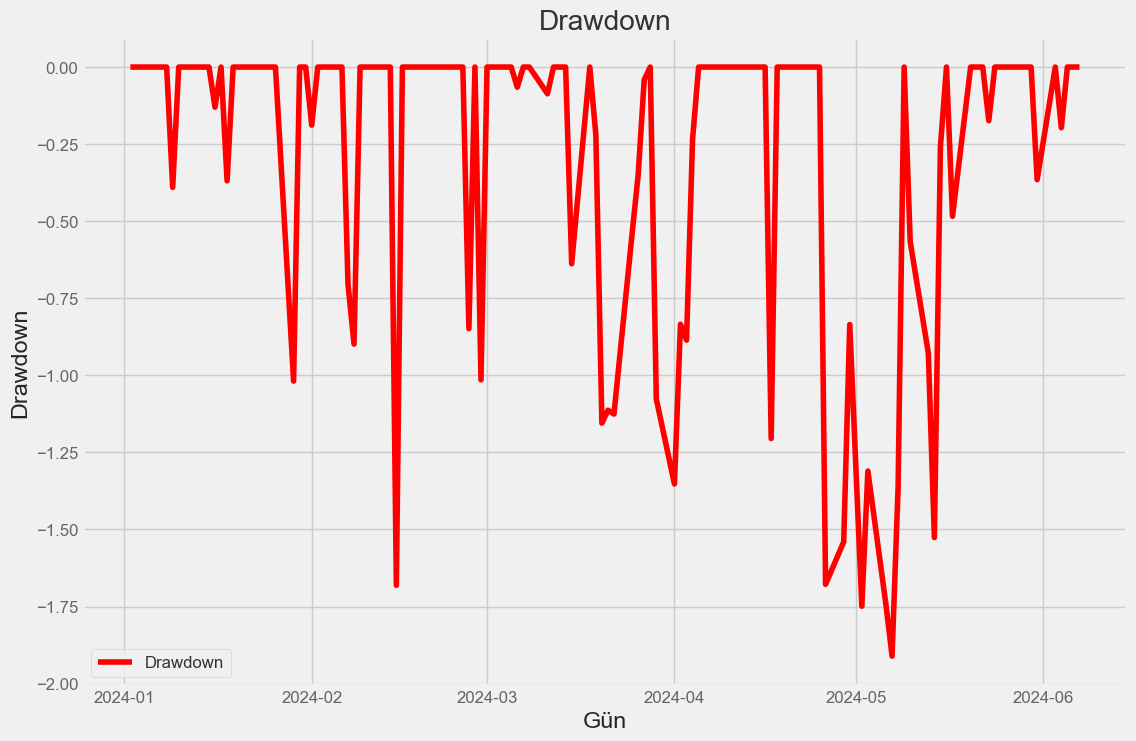

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Convert to DataFrame
cumulative_returns = np.cumprod(1+returns["Gerçek"])


def calculate_drawdowns(returns):
    peak = returns[0]
    drawdowns = [0]  # İlk değer 0, çünkü başlangıçta herhangi bir drawdown yok

    for ret in returns[1:]:
        if ret > peak:
            peak = ret
            drawdowns.append(0)  # Yeni zirve bulunduğunda drawdown sıfırlanır
        else:
            drawdowns.append(-100*((peak - ret) / peak))  # Drawdown hesaplanır
    
    return drawdowns

# Drawdown'ları hesapla
drawdowns = calculate_drawdowns(cumulative_returns)


# Grafik çizimi
plt.figure(figsize=(12, 8))
plt.plot(returns.index, drawdowns, label='Drawdown', color='red', linestyle='-')
plt.xlabel('Gün')
plt.ylabel('Drawdown')
plt.title('Drawdown')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
feature_importance = model.get_feature_importance(type='FeatureImportance')

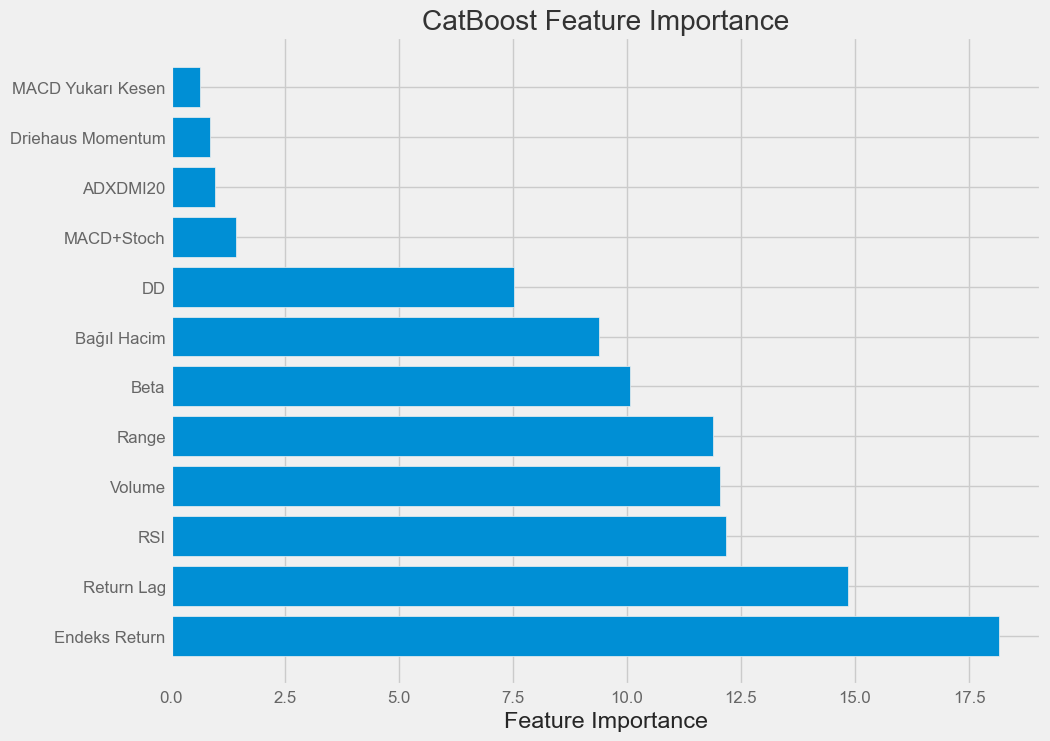

In [ ]:
import catboost
feature_importance = model.get_feature_importance(type='FeatureImportance')
# Özellik isimlerini alın
feature_names = model.feature_names_

# Özellik önemlerini bir sözlükte saklayın
feature_importance_dict = dict(zip(feature_names, feature_importance))

# Özellik önemlerine göre sıralayın
sorted_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Görselleştirme
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_importance)), [val[1] for val in sorted_importance], align='center')
plt.yticks(range(len(sorted_importance)), [val[0] for val in sorted_importance])
plt.xlabel('Feature Importance')
plt.title('CatBoost Feature Importance')
plt.show()

In [ ]:
veri["date"]=pd.to_datetime(veri.index)

In [ ]:
satışlar = []
indexler = veri['date'].unique()

for date in veri['date']:
    future_dates = indexler[indexler > date]
    if len(future_dates) >= 2:
        satış_tarihi = future_dates[1]
    else:
        satış_tarihi = pd.NaT
    satışlar.append(satış_tarihi)

veri['satış_tarihi'] = satışlar

In [ ]:
df["date"]=pd.to_datetime(df.index)

In [ ]:
veri['Alış Fiyatı'] = veri.set_index(['date', 'Hisse']).index.map(df.set_index(['date', 'Hisse'])['Adj Close'])
veri['Satış Fiyatı'] = veri.set_index(['satış_tarihi', 'Hisse']).index.map(df.set_index(['date', 'Hisse'])['Open'])

veri

,Gerçek,Tahmin,Hisse,Tavan,Var,Metrik,Ağırlık,Ağırlıklı Getiri,date,satış_tarihi,Alış Fiyatı,Satış Fiyatı
Date,,,,,,,,,,,,
2024-01-02,1.888504,-0.090603,ANSGR.IS,0,4.969860,4.969860,0.344393,0.650387,2024-01-02,2024-01-04,63.50,64.75
2024-01-02,1.578768,-0.097690,TURSG.IS,0,7.579205,7.579205,0.525211,0.829185,2024-01-02,2024-01-04,42.20,42.90
2024-01-02,-2.766367,-0.103599,AKCNS.IS,0,1.881728,1.881728,0.130397,-0.360725,2024-01-02,2024-01-04,148.90,144.90
2024-01-03,-0.234321,-0.809151,ANSGR.IS,0,3.937444,3.937444,0.424522,-0.099474,2024-01-03,2024-01-05,64.80,64.70
2024-01-03,3.895096,-0.945862,TURSG.IS,0,5.337569,5.337569,0.575478,2.241543,2024-01-03,2024-01-05,41.76,43.42
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-06,-80.061802,-0.688146,PETKM.IS,0,7.648562,7.648562,0.726411,-58.157809,2024-06-06,NaT,21.98,NaN
2024-06-06,-96.771358,-0.706714,TURSG.IS,0,1.739682,1.739682,0.165224,-15.988937,2024-06-06,NaT,81.00,NaN
2024-06-07,-98.464471,-0.836546,ULKER.IS,0,1.750268,1.750268,0.410433,-40.413107,2024-06-07,NaT,159.70,NaN


In [ ]:
veri=veri.rename(columns={"date":"Alış Tarihi","Gerçek":"Kar","satış_tarihi":"Satış Tarihi"})
veri

,Kar,Tahmin,Hisse,Tavan,Var,Metrik,Ağırlık,Ağırlıklı Getiri,Alış Tarihi,Satış Tarihi,Alış Fiyatı,Satış Fiyatı
Date,,,,,,,,,,,,
2024-01-02,1.888504,-0.090603,ANSGR.IS,0,4.969860,4.969860,0.344393,0.650387,2024-01-02,2024-01-04,63.50,64.75
2024-01-02,1.578768,-0.097690,TURSG.IS,0,7.579205,7.579205,0.525211,0.829185,2024-01-02,2024-01-04,42.20,42.90
2024-01-02,-2.766367,-0.103599,AKCNS.IS,0,1.881728,1.881728,0.130397,-0.360725,2024-01-02,2024-01-04,148.90,144.90
2024-01-03,-0.234321,-0.809151,ANSGR.IS,0,3.937444,3.937444,0.424522,-0.099474,2024-01-03,2024-01-05,64.80,64.70
2024-01-03,3.895096,-0.945862,TURSG.IS,0,5.337569,5.337569,0.575478,2.241543,2024-01-03,2024-01-05,41.76,43.42
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-06,-80.061802,-0.688146,PETKM.IS,0,7.648562,7.648562,0.726411,-58.157809,2024-06-06,NaT,21.98,NaN
2024-06-06,-96.771358,-0.706714,TURSG.IS,0,1.739682,1.739682,0.165224,-15.988937,2024-06-06,NaT,81.00,NaN
2024-06-07,-98.464471,-0.836546,ULKER.IS,0,1.750268,1.750268,0.410433,-40.413107,2024-06-07,NaT,159.70,NaN


In [ ]:
veri[["Alış Tarihi","Satış Tarihi","Hisse","Alış Fiyatı","Satış Fiyatı","Ağırlık","Ağırlıklı Getiri","Kar"]].to_excel("C:/Users/Bora/Documents/Github/streamlit_trading/veri.xlsx")

In [ ]:
veri=pd.read_excel("veri.xlsx")
veri

,Unnamed: 0,Alış Tarihi,Satış Tarihi,Hisse,Alış Fiyatı,Satış Fiyatı,Ağırlık,Ağırlıklı Getiri,Kar
0,0,2024-01-02,2024-01-04,ANSGR.IS,63.5,64.75,0.348911,0.658921,1.888504
1,1,2024-01-02,2024-01-04,TURSG.IS,42.2,43.40,0.502618,0.793517,1.578768
2,2,2024-01-02,2024-01-04,AKCNS.IS,148.9,145.50,0.148471,-0.410725,-2.766367
3,3,2024-01-03,2024-01-05,YEOTK.IS,178.8,185.00,0.023224,0.065685,2.828277
4,4,2024-01-03,2024-01-05,ANSGR.IS,64.8,66.10,0.425583,-0.099723,-0.234321
...,...,...,...,...,...,...,...,...,...
311,311,2024-06-04,2024-06-06,TURSG.IS,81.1,81.00,0.181157,0.164207,0.906436
312,312,2024-06-04,2024-06-06,KRDMD.IS,30.8,30.34,0.427287,0.465244,1.088831
313,313,2024-06-05,NaT,ANSGR.IS,117.3,NaN,0.173299,-12.992801,-74.973436
314,314,2024-06-05,NaT,TTKOM.IS,49.5,NaN,0.610076,-55.103538,-90.322424
